In [5]:
%load_ext autoreload

%autoreload 
import os
os.chdir("..\\..\\")


In [450]:
import networkx as nx
import numpy as np
from src.visualization.graph_plot_utils import plot_graph, plot_infection
import collections, functools, operator 
import pandas as pd
import matplotlib.pyplot as plt

In [464]:
# Start with 1% of population infected
def initial_infection(G, pct):
    size = int(len(G.nodes) * pct) 
    infected = np.random.choice(G.nodes, size = size)
    for node in G.nodes():
        if node in infected: G.nodes[node].update({'infected' : 1})
        else: G.nodes[node].update({'infected' : 0})
        
def spread_one_step(G, chance_to_infect = 0.3):
    newly_infected = []
    for node, adjacencies in enumerate(G.adjacency()):
        if G.nodes[node]['infected']:
            for contact in adjacencies[1].keys():
                if G.nodes[contact]['infected'] == 0 and np.random.random() < chance_to_infect:
                        newly_infected.append(contact)
     
    for node in np.unique(newly_infected):
        G.nodes[node].update({'infected' : 1})
        
    return len(newly_infected)

def current_status(G):
    nodes = np.array(G.nodes(data=True))[:,1]
    result = dict(functools.reduce(operator.add, 
         map(collections.Counter, nodes)))
    return result

In [465]:
G = nx.relaxed_caveman_graph(25, 4, 0.25, seed=42)
initial_infection(G, .05)
plot_infection(G)

In [471]:
G = nx.relaxed_caveman_graph(250, 4, 0.25, seed=42)
#G = nx.scale_free_graph(1000)

initial_infection(G, .05)

pop = len(G.nodes)
i = current_status(G)['infected'] / pop
s = (pop - i) / pop
newly_infected = pop * .05

status = current_status(G)
data = [[s,i, newly_infected]]
while status['infected'] < 0.9*len(G.nodes):
    newly_infected = spread_one_step(G)
    status = current_status(G)
    i = status['infected'] / pop
    s = (pop -  status['infected']) / pop
    data.append([s, i, newly_infected])

time_series = pd.DataFrame(data, columns = ['susceptible', 'infected', 'newly_infected'])

In [467]:
time_series

,susceptible,infected,newly_infected
0,0.999952,0.048,50.0
1,0.914000,0.086,39.0
2,0.869000,0.131,45.0
3,0.819000,0.181,53.0
4,0.769000,0.231,52.0
5,0.711000,0.289,62.0
6,0.672000,0.328,41.0
7,0.612000,0.388,63.0
8,0.558000,0.442,62.0
9,0.510000,0.490,50.0


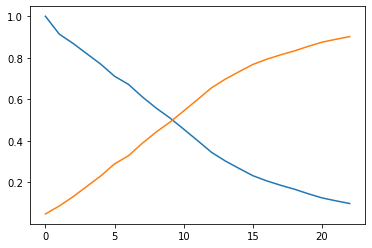

In [468]:
plt.plot(time_series.index, time_series['susceptible'])
plt.plot(time_series.index, time_series['infected'])


In [469]:
def add_hub(graph, p=1):
    graph_matrix = nx.to_numpy_matrix(graph)

    connections_to_hub = np.reshape(np.random.choice(2, size = graph_matrix.shape[0], p=[1-p, p]), (-1,1))
    connections_from_hub = np.reshape(np.append(connections_to_hub, 0), (1,-1))
    
    graph_matrix = np.append(graph_matrix, connections_to_hub, axis=1)
    
    graph_matrix = np.append(graph_matrix, connections_from_hub, axis=0)
    
    return nx.from_numpy_matrix(graph_matrix)


In [478]:
G = nx.relaxed_caveman_graph(25, 4, 0.25, seed=42)
initial_infection(G, .05)
plot_infection(G)

In [472]:
G = nx.relaxed_caveman_graph(250, 4, 0.25, seed=42)
G = add_hub(G)
initial_infection(G, .05)

pop = len(G.nodes)
i = current_status(G)['infected'] / pop
s = (pop - i) / pop
newly_infected = pop * .05

status = current_status(G)
data = [[s,i, newly_infected]]
while status['infected'] < 0.9*len(G.nodes):
    newly_infected = spread_one_step(G)
    status = current_status(G)
    i = status['infected'] / pop
    s = (pop -  status['infected']) / pop
    data.append([s, i, newly_infected])
    
time_series = pd.DataFrame(data, columns = ['susceptible', 'infected', 'newly_infected'])

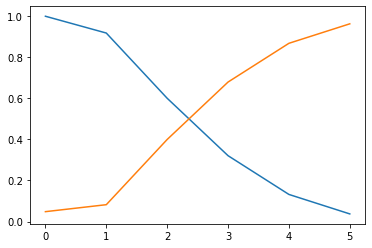

In [473]:
plt.plot(time_series.index, time_series['susceptible'])
plt.plot(time_series.index, time_series['infected'])


# Disease evolution Model

## source : https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf

